In [1]:
import os
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Configuration
CONFIG = {
    'oxford_data_dir': '/kaggle/input/oxford5k/images/',
    'oxford_gt_path': '/kaggle/input/oxford5k/groundtruth.json',
    'paris_data_dir': '/kaggle/input/paris6k/Paris6k/',
    'batch_size': 32,  # Larger batch size for 2 GPUs
    'num_epochs': 80,
    'learning_rate': 1e-5,
    'num_workers': 4,
    'embedding_dim': 2048,
    'backbone': 'vgg19', # Options: 'resnet50', 'vgg19'
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

print(f"Using Device: {CONFIG['device']}")
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")

Using Device: cuda
Using 2 GPUs!


In [2]:
class TripletDataset(Dataset):
    def __init__(self, oxford_dir, oxford_gt, paris_dir, transform=None):
        self.transform = transform
        self.class_to_images = {}
        
        # --- Load Oxford5k (from JSON) ---
        with open(oxford_gt, 'r') as f:
            oxford_data = json.load(f)
            
        for class_name, items in oxford_data.items():
            imgs = items.get('good', []) + items.get('ok', [])
            full_paths = [os.path.join(oxford_dir, img) for img in imgs]
            if len(full_paths) > 0:
                self.class_to_images[class_name] = full_paths

        # --- Load Paris6k (from Folders) ---
        for class_name in os.listdir(paris_dir):
            class_dir = os.path.join(paris_dir, class_name)
            if os.path.isdir(class_dir):
                imgs = [os.path.join(class_dir, f) for f in os.listdir(class_dir) 
                        if f.endswith(('.jpg', '.png'))]
                if len(imgs) > 0:
                    # Check if class exists to merge or create new
                    if class_name in self.class_to_images:
                        self.class_to_images[class_name].extend(imgs)
                    else:
                        self.class_to_images[class_name] = imgs
        
        # Create a list of classes and all images for indexing
        self.classes = list(self.class_to_images.keys())
        self.all_images = []
        for c in self.classes:
            self.all_images.extend([(img, c) for img in self.class_to_images[c]])

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        # 1. Anchor
        anchor_path, anchor_label = self.all_images[idx]
        
        # 2. Positive (Same class, different image)
        pos_list = self.class_to_images[anchor_label]
        if len(pos_list) > 1:
            pos_path = random.choice(pos_list)
            while pos_path == anchor_path: # Ensure distinct positive
                pos_path = random.choice(pos_list)
        else:
            pos_path = anchor_path # Fallback if only 1 image in class

    # 3. Negative (Different class)
        neg_label = random.choice(self.classes)
        while neg_label == anchor_label:
            neg_label = random.choice(self.classes)
        neg_path = random.choice(self.class_to_images[neg_label])

        # Load Images
        anchor_img = self._load_image(anchor_path)
        pos_img = self._load_image(pos_path)
        neg_img = self._load_image(neg_path)

        return anchor_img, pos_img, neg_img

    def _load_image(self, path):
        try:
            img = Image.open(path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            return img
        except Exception as e:
            # Simple fallback for corrupt images during training
            return torch.zeros((3, 224, 224))

# Transforms
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
dataset = TripletDataset(CONFIG['oxford_data_dir'], CONFIG['oxford_gt_path'], CONFIG['paris_data_dir'], transform=transforms_train)
train_loader = DataLoader(dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['num_workers'])

In [4]:
class RetrievalNet(nn.Module):
    def __init__(self, backbone_name='resnet50'):
        super(RetrievalNet, self).__init__()
        
        if backbone_name == 'resnet50':
            base = models.resnet50(pretrained=True)
            self.backbone = nn.Sequential(*list(base.children())[:-1]) # Remove fc layer
            self.embed_dim = 2048
        elif backbone_name == 'vgg19':
            base = models.vgg19(pretrained=True)
            # VGG is different, we usually take the output of the classifier's first dense layer or pool
            # For simplicity in VGG, we use the features + adaptive pool
            self.backbone = base.features
            self.pool = nn.AdaptiveAvgPool2d((1, 1))
            self.embed_dim = 512
        
        # Optional: Add a small projection head if you want lower dim features
        # self.fc = nn.Linear(self.embed_dim, 512) 
        
    def forward(self, x):
        x = self.backbone(x)
        
        # Handle VGG shape
        if len(x.shape) == 4: 
             # if using VGG features directly, we need to pool
             if x.size(2) != 1: 
                 x = F.adaptive_avg_pool2d(x, (1,1))
             x = x.view(x.size(0), -1)
        else:
             x = x.view(x.size(0), -1)
             
        # L2 Normalization (Critical for Cosine Similarity)
        # We normalize vectors so they lie on a hypersphere
        x = F.normalize(x, p=2, dim=1)
        return x

# Initialize & Multi-GPU
model = RetrievalNet(backbone_name='resnet50') # Change to 'vgg19' if needed
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)
model = model.to(CONFIG['device'])

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 214MB/s]


Using 2 GPUs!


In [5]:
def train_cbir(model, loader, optimizer, num_epochs):
    # Standard Triplet Margin Loss
    criterion = nn.TripletMarginLoss(margin=1.0, p=2)
    history = []
    # Initialize best_loss to infinity so the first epoch always triggers a save
    best_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for anchor, pos, neg in pbar:
            anchor, pos, neg = anchor.to(CONFIG['device']), pos.to(CONFIG['device']), neg.to(CONFIG['device'])
            
            optimizer.zero_grad()
            
            # Forward pass all 3
            a_emb = model(anchor)
            p_emb = model(pos)
            n_emb = model(neg)
            
            # Calculate Loss
            loss = criterion(a_emb, p_emb, n_emb)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
            
        epoch_loss = running_loss / len(loader)
        history.append(epoch_loss)
        print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")

        # Unwrap the model if it's on multiple GPUs (DataParallel)
        # This ensures the saved keys don't have 'module.' prefix, making loading easier
        if isinstance(model, nn.DataParallel):
            model_state = model.module.state_dict()
        else:
            model_state = model.state_dict()
            
        # 1. Save BEST Model (Lowest Loss)
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model_state, "best_model.pth")
            print(f"  -> New Best Model found and saved! (Loss: {best_loss:.4f})")
            
        # 2. Save LAST Model (Always overwrite at end of epoch)
        torch.save(model_state, "last_model.pth")
        
    print("Training finished.")
    print(f"Best Loss: {best_loss:.4f}")
        
    return history

optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])

# Start Training
history = train_cbir(model, train_loader, optimizer, num_epochs=CONFIG['num_epochs'])

Epoch 1/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 1 Loss: 0.8981
  -> New Best Model found and saved! (Loss: 0.8981)


Epoch 2/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 2 Loss: 0.7304
  -> New Best Model found and saved! (Loss: 0.7304)


Epoch 3/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 3 Loss: 0.6030
  -> New Best Model found and saved! (Loss: 0.6030)


Epoch 4/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 4 Loss: 0.5074
  -> New Best Model found and saved! (Loss: 0.5074)


Epoch 5/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 5 Loss: 0.4370
  -> New Best Model found and saved! (Loss: 0.4370)


Epoch 6/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 6 Loss: 0.3794
  -> New Best Model found and saved! (Loss: 0.3794)


Epoch 7/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 7 Loss: 0.3062
  -> New Best Model found and saved! (Loss: 0.3062)


Epoch 8/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 8 Loss: 0.2689
  -> New Best Model found and saved! (Loss: 0.2689)


Epoch 9/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 9 Loss: 0.2319
  -> New Best Model found and saved! (Loss: 0.2319)


Epoch 10/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 10 Loss: 0.2017
  -> New Best Model found and saved! (Loss: 0.2017)


Epoch 11/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 11 Loss: 0.1766
  -> New Best Model found and saved! (Loss: 0.1766)


Epoch 12/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 12 Loss: 0.1560
  -> New Best Model found and saved! (Loss: 0.1560)


Epoch 13/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 13 Loss: 0.1393
  -> New Best Model found and saved! (Loss: 0.1393)


Epoch 14/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 14 Loss: 0.1250
  -> New Best Model found and saved! (Loss: 0.1250)


Epoch 15/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 15 Loss: 0.1189
  -> New Best Model found and saved! (Loss: 0.1189)


Epoch 16/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 16 Loss: 0.1100
  -> New Best Model found and saved! (Loss: 0.1100)


Epoch 17/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 17 Loss: 0.0932
  -> New Best Model found and saved! (Loss: 0.0932)


Epoch 18/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 18 Loss: 0.0937


Epoch 19/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 19 Loss: 0.0768
  -> New Best Model found and saved! (Loss: 0.0768)


Epoch 20/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 20 Loss: 0.0711
  -> New Best Model found and saved! (Loss: 0.0711)


Epoch 21/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 21 Loss: 0.0681
  -> New Best Model found and saved! (Loss: 0.0681)


Epoch 22/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 22 Loss: 0.0618
  -> New Best Model found and saved! (Loss: 0.0618)


Epoch 23/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 23 Loss: 0.0583
  -> New Best Model found and saved! (Loss: 0.0583)


Epoch 24/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 24 Loss: 0.0528
  -> New Best Model found and saved! (Loss: 0.0528)


Epoch 25/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 25 Loss: 0.0521
  -> New Best Model found and saved! (Loss: 0.0521)


Epoch 26/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 26 Loss: 0.0493
  -> New Best Model found and saved! (Loss: 0.0493)


Epoch 27/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 27 Loss: 0.0449
  -> New Best Model found and saved! (Loss: 0.0449)


Epoch 28/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 28 Loss: 0.0441
  -> New Best Model found and saved! (Loss: 0.0441)


Epoch 29/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 29 Loss: 0.0385
  -> New Best Model found and saved! (Loss: 0.0385)


Epoch 30/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 30 Loss: 0.0387


Epoch 31/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 31 Loss: 0.0408


Epoch 32/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 32 Loss: 0.0433


Epoch 33/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 33 Loss: 0.0409


Epoch 34/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 34 Loss: 0.0345
  -> New Best Model found and saved! (Loss: 0.0345)


Epoch 35/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 35 Loss: 0.0301
  -> New Best Model found and saved! (Loss: 0.0301)


Epoch 36/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 36 Loss: 0.0312


Epoch 37/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 37 Loss: 0.0325


Epoch 38/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 38 Loss: 0.0302


Epoch 39/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 39 Loss: 0.0274
  -> New Best Model found and saved! (Loss: 0.0274)


Epoch 40/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 40 Loss: 0.0255
  -> New Best Model found and saved! (Loss: 0.0255)


Epoch 41/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 41 Loss: 0.0280


Epoch 42/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 42 Loss: 0.0273


Epoch 43/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 43 Loss: 0.0260


Epoch 44/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 44 Loss: 0.0285


Epoch 45/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 45 Loss: 0.0236
  -> New Best Model found and saved! (Loss: 0.0236)


Epoch 46/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 46 Loss: 0.0191
  -> New Best Model found and saved! (Loss: 0.0191)


Epoch 47/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 47 Loss: 0.0217


Epoch 48/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 48 Loss: 0.0237


Epoch 49/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 49 Loss: 0.0264


Epoch 50/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 50 Loss: 0.0236


Epoch 51/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 51 Loss: 0.0226


Epoch 52/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 52 Loss: 0.0230


Epoch 53/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 53 Loss: 0.0211


Epoch 54/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 54 Loss: 0.0195


Epoch 55/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 55 Loss: 0.0193


Epoch 56/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 56 Loss: 0.0193


Epoch 57/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 57 Loss: 0.0166
  -> New Best Model found and saved! (Loss: 0.0166)


Epoch 58/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 58 Loss: 0.0184


Epoch 59/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 59 Loss: 0.0174


Epoch 60/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 60 Loss: 0.0219


Epoch 61/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 61 Loss: 0.0170


Epoch 62/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 62 Loss: 0.0182


Epoch 63/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 63 Loss: 0.0194


Epoch 64/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 64 Loss: 0.0151
  -> New Best Model found and saved! (Loss: 0.0151)


Epoch 65/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 65 Loss: 0.0174


Epoch 66/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 66 Loss: 0.0188


Epoch 67/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 67 Loss: 0.0167


Epoch 68/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 68 Loss: 0.0166


Epoch 69/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 69 Loss: 0.0131
  -> New Best Model found and saved! (Loss: 0.0131)


Epoch 70/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 70 Loss: 0.0124
  -> New Best Model found and saved! (Loss: 0.0124)


Epoch 71/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 71 Loss: 0.0170


Epoch 72/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 72 Loss: 0.0172


Epoch 73/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 73 Loss: 0.0133


Epoch 74/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 74 Loss: 0.0141


Epoch 75/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 75 Loss: 0.0153


Epoch 76/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 76 Loss: 0.0159


Epoch 77/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 77 Loss: 0.0149


Epoch 78/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 78 Loss: 0.0166


Epoch 79/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 79 Loss: 0.0111
  -> New Best Model found and saved! (Loss: 0.0111)


Epoch 80/80:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 80 Loss: 0.0134
Training finished.
Best Loss: 0.0111


In [6]:
# Save Model
# torch.save(model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict(), "resnet50_cbir_model.pth")

In [7]:
def create_image_database(model, dataset):
    model.eval()
    database = {
        'paths': [],
        'embeddings': [],
        'labels': []
    }
    
    # We use a simple loader that just returns images (not triplets)
    # We can reuse the dataset but just access items manually or build a simple wrapper
    # Let's iterate through dataset.all_images directly for simplicity
    
    transform = transforms_train # Use same transform (or remove augmentation)
    # Ideally use a validation transform without flip, but flip is okay for features
    
    print("Building Index...")
    batch_size = 64
    current_batch = []
    current_paths = []
    current_labels = []
    
    with torch.no_grad():
        for path, label in tqdm(dataset.all_images):
            try:
                img = Image.open(path).convert('RGB')
                img = transform(img)
                
                current_batch.append(img)
                current_paths.append(path)
                current_labels.append(label)
                
                if len(current_batch) >= batch_size:
                    batch_tensor = torch.stack(current_batch).to(CONFIG['device'])
                    emb = model(batch_tensor)
                    database['embeddings'].append(emb.cpu())
                    database['paths'].extend(current_paths)
                    database['labels'].extend(current_labels)
                    
                    current_batch = []
                    current_paths = []
                    current_labels = []
            except:
                pass
        
        # Process remaining
        if current_batch:
            batch_tensor = torch.stack(current_batch).to(CONFIG['device'])
            emb = model(batch_tensor)
            database['embeddings'].append(emb.cpu())
            database['paths'].extend(current_paths)
            database['labels'].extend(current_labels)

    # Concatenate all embeddings into one large tensor
    database['embeddings'] = torch.cat(database['embeddings'])
    return database

# Build the database (Index)
gallery_db = create_image_database(model, dataset)

Building Index...


  0%|          | 0/6980 [00:00<?, ?it/s]

In [8]:
# Save the gallery database (Index) to a file
index_save_path = "gallery_index.pth"
torch.save(gallery_db, index_save_path)
print(f"Index saved to {index_save_path}")

Index saved to gallery_index.pth


In [9]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import os

# --- Configuration ---
CONFIG = {
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'backbone': 'resnet50'
}

# 1. Load the Model Architecture & Weights
# (Make sure the RetrievalNet class is defined in your notebook)
model = RetrievalNet(backbone_name=CONFIG['backbone'])

# Handle DataParallel saving: if saved with DataParallel, keys have 'module.' prefix
state_dict = torch.load("best_model.pth", map_location=CONFIG['device'])
# If you saved the model wrapped in DataParallel but are loading on single GPU/CPU:
if list(state_dict.keys())[0].startswith('module.'):
    state_dict = {k[7:]: v for k, v in state_dict.items()}

model.load_state_dict(state_dict)
model.to(CONFIG['device'])
model.eval()
print("Model loaded successfully.")

# 2. Load the Index
index_path = "gallery_index.pth"
loaded_gallery_db = torch.load(index_path, map_location=CONFIG['device'])
print(f"Index loaded. Contains {len(loaded_gallery_db['paths'])} images.")

# 3. Search Function (Same as before)
def search_cbir(query_path, database, model, top_k=5):
    # Transforms (Must match training transforms - specifically normalization)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    try:
        img = Image.open(query_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(CONFIG['device'])
    except Exception as e:
        print(f"Error reading query: {e}")
        return
        
    with torch.no_grad():
        # Extract Query Feature
        query_emb = model(img_tensor) 
        
        # Calculate Similarity (Cosine)
        # Ensure database embeddings are on the same device
        db_embs = database['embeddings'].to(CONFIG['device'])
        
        similarities = torch.mm(query_emb, db_embs.t())
        
        # Rank
        scores, indices = torch.sort(similarities, dim=1, descending=True)
        scores = scores.cpu().numpy()[0]
        indices = indices.cpu().numpy()[0]
        
    # Display Results
    print(f"--- Query Image: {os.path.basename(query_path)} ---")
    plt.figure(figsize=(15, 5))
    
    # Show Query
    plt.subplot(1, top_k+1, 1)
    plt.imshow(Image.open(query_path))
    plt.title("Query")
    plt.axis('off')
    
    for i in range(top_k):
        idx = indices[i]
        score = scores[i]
        result_path = database['paths'][idx]
        
        plt.subplot(1, top_k+1, i+2)
        try:
            plt.imshow(Image.open(result_path))
            plt.title(f"#{i+1} {score:.2f}")
        except:
            plt.title("Img Not Found")
        plt.axis('off')
    plt.show()



Model loaded successfully.
Index loaded. Contains 6960 images.


--- Query Image: paris_eiffel_000040.jpg ---


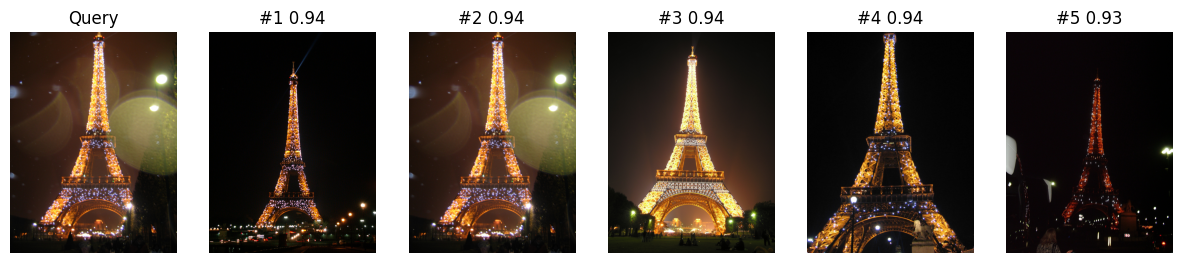

In [10]:
# --- Test with an external image ---
test_query_path = "/kaggle/input/paris6k/Paris6k/eiffel/paris_eiffel_000040.jpg"
search_cbir(test_query_path, loaded_gallery_db, model)

--- Query Image: keble_000214.jpg ---


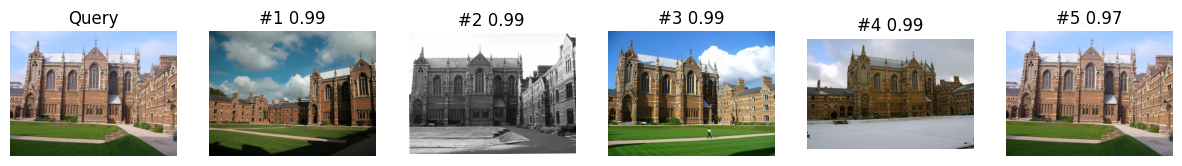

In [11]:
test_query_path = "/kaggle/input/oxford5k/images/keble_000214.jpg"
search_cbir(test_query_path, loaded_gallery_db, model)

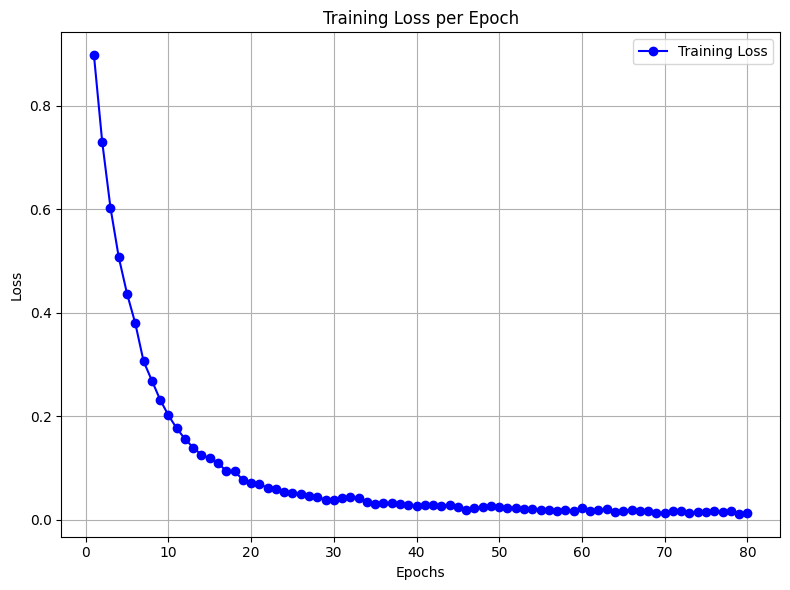

In [12]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # history is a list of floats, so we take len(history) directly
    epochs = range(1, len(history) + 1)
    
    plt.figure(figsize=(8, 6))
    
    # Plot Loss
    plt.plot(epochs, history, 'b-o', label='Training Loss')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_convergence_plot.png') 
    plt.show()

# Run the plot
plot_training_history(history)

In [13]:
# plot_training_history(history)